In [2]:
! pip install gensim


You should consider upgrading via the 'C:\Users\HP\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Epoch 60/60, Validation Loss: 0.1140
Validation Macro F1: 0.7159


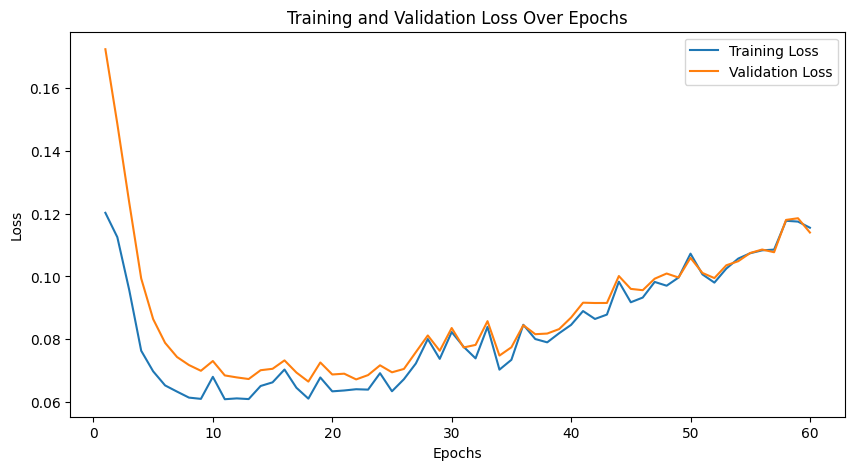

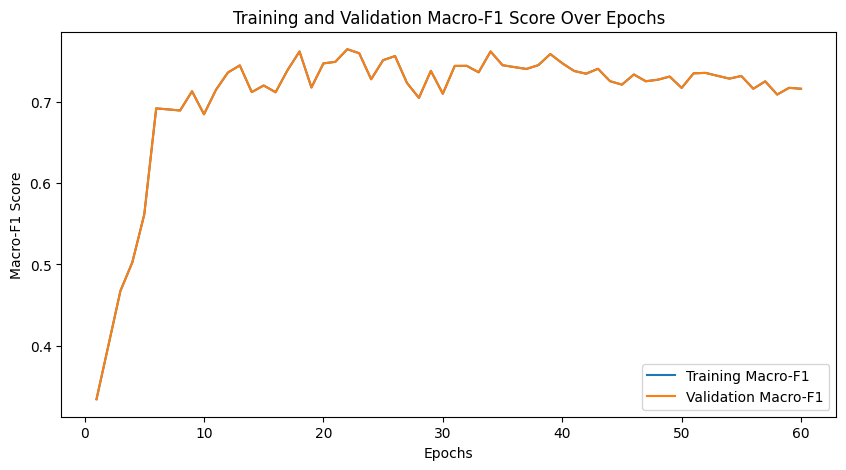

In [9]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors

def load_word2vec_embeddings(file_path, word_to_index, embedding_dim):
    model = KeyedVectors.load_word2vec_format(file_path, binary=True)
    embedding_matrix = np.zeros((len(word_to_index) + 1, embedding_dim))

    for word, index in word_to_index.items():
        if word in model:
            embedding_matrix[index] = model[word]
        else:
            # Use a default value (e.g., zero vector) when the word is not in the model
            embedding_matrix[index] = np.zeros(embedding_dim)

    return embedding_matrix
# Load processed data
with open("processed_train_data.json", "r") as f_train, open("processed_val_data.json", "r") as f_val:
    processed_train_data = json.load(f_train)
    processed_val_data = json.load(f_val)

texts_train = [entry["text"] for entry in processed_train_data.values()]
labels_train = [entry["labels"] for entry in processed_train_data.values()]

texts_val = [entry["text"] for entry in processed_val_data.values()]
labels_val = [entry["labels"] for entry in processed_val_data.values()]

# Build word_to_index
word_to_index = {}
index = 1
for entry in processed_train_data.values():
    tokens = entry["text"].split()
    for token in tokens:
        if token not in word_to_index:
            word_to_index[token] = index
            index += 1

word_to_index["<unk>"] = 0
embedding_dim = 300  # Adjust this based on the Word2Vec embedding dimension

# Load Word2Vec embeddings
word2vec_embeddings_path = "GoogleNews-vectors-negative300.bin" 
embedding_matrix_word2vec = load_word2vec_embeddings(word2vec_embeddings_path, word_to_index, embedding_dim)
label_to_index = {'O': 0, 'B': 1, 'I': 2}
# Convert data to indices
X_train = [[word_to_index.get(token, word_to_index["<unk>"]) for token in text.split()] for text in texts_train]
y_train = [[label_to_index[label] for label in entry] for entry in labels_train]
X_val = [[word_to_index.get(token, word_to_index["<unk>"]) for token in text.split()] for text in texts_val]
y_val = [[label_to_index[label] for label in entry] for entry in labels_val]

# Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.LongTensor(self.X[idx]), torch.LongTensor(self.y[idx])

def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets = pad_sequence(targets, batch_first=True, padding_value=0)
    return inputs, targets

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Model definition
class SimpleRNNWord2Vec(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, output_size):
        super(SimpleRNNWord2Vec, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        output = self.fc(output)
        return output

# Initialize model, criterion, and optimizer
hidden_size = 100
output_size = len(label_to_index)
model_word2vec = SimpleRNNWord2Vec(embedding_matrix_word2vec, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_word2vec.parameters(), lr=0.001)

# Training loop
num_epochs = 60
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in range(num_epochs):
    model_word2vec.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model_word2vec(inputs)
        loss = criterion(outputs.view(-1, output_size), targets.view(-1))
        loss.backward()
        optimizer.step()

    model_word2vec.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in val_loader:
            outputs = model_word2vec(inputs)
            loss = criterion(outputs.view(-1, output_size), targets.view(-1))
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=2).cpu().numpy()
            targets = targets.cpu().numpy()

            all_preds.extend(preds)
            all_targets.extend(targets)

        val_loss /= len(val_loader)
        val_macro_f1 = f1_score(np.concatenate(all_targets, axis=0), np.concatenate(all_preds, axis=0), average='macro')

        train_losses.append(loss.item())
        val_losses.append(val_loss)
        train_f1_scores.append(val_macro_f1)
        val_f1_scores.append(val_macro_f1)

        if epoch == num_epochs - 1:
            print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')
            print(f'Validation Macro F1: {val_macro_f1:.4f}')

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.savefig('plots/rnn_word2vec/Loss.png')  # Save the plot
plt.show()

# Plotting F1 Score
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_f1_scores, label='Training Macro-F1')
plt.plot(range(1, num_epochs+1), val_f1_scores, label='Validation Macro-F1')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1 Score')
plt.title('Training and Validation Macro-F1 Score Over Epochs')
plt.legend()
plt.savefig('plots/rnn_word2vec/Macro.png')  # Save the plot
plt.show()

# Save the model
torch.save(model_word2vec.state_dict(), "models/rnn_word2vec.pth")

In [11]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

with open("processed_test_data.json", "r") as f_test:
    processed_test_data = json.load(f_test)

texts_test = [entry["text"] for entry in processed_test_data.values()]
labels_test = [entry["labels"] for entry in processed_test_data.values()]

X_test = [[word_to_index.get(token, word_to_index["<unk>"]) for token in text.split()] for text in texts_test]
y_test = [[label_to_index[label] for label in entry] for entry in labels_test]

test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Ensure that the model is in evaluation mode
model_word2vec.eval()

# No need for an epoch loop when testing
all_preds_test = []
all_targets_test = []

with torch.no_grad():
    for inputs_test, targets_test in test_loader:
        outputs_test = model_word2vec(inputs_test)
        preds_test = torch.argmax(outputs_test, dim=2).cpu().numpy()
        targets_test = targets_test.cpu().numpy()

        all_preds_test.extend(preds_test)
        all_targets_test.extend(targets_test)

# Concatenate results
all_preds_test = np.concatenate(all_preds_test, axis=0)
all_targets_test = np.concatenate(all_targets_test, axis=0)

# Calculate accuracy and F1 score
test_accuracy = accuracy_score(all_targets_test, all_preds_test)
test_macro_f1 = f1_score(all_targets_test, all_preds_test, average='macro')

print(f'Final Test Accuracy: {test_accuracy:.4f}, Final Test Macro F1: {test_macro_f1:.4f}')


Final Test Accuracy: 0.9671, Final Test Macro F1: 0.6569
